In [1]:
from HeaderP import *

In [2]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)

    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if plotlegend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in trange(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<10:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
    

# Check simiulation with a bar

In [3]:
#simNo='6_96e11'
#simNo='2_79e12'
simNo='7_55e11'
#z='0'
#z='0_097' 
#z='0_255'
z='0'
# app-center passage
#z='0_25' 
#z='0_2' 
#z='0_195' 
#z='0_19' 
#z='0_1' 
# peri-center passage
#z='0_34' 
#z='0_35' 
#z='0_36' 
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5

In [4]:
if simNo=='data':
    data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
    data['z_today']=data['z']
    data['x_today']=data['X']
    data['y_today']=data['Y']
    data['feh_scale']=data['M_H']
    data['ofe_scale']=data['O_FE']
    data['age']=data['Age']
elif select:
    data=pd.read_pickle('Data/Buck_g'+simNo+'_apogee_selec.pkl')
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
elif not select:
    if z=='0':
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'.pkl')
    else:
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
        try:
            data['x_today']=data['x']
            data['y_today']=data['y']
            data['z_today']=data['z']
        except:
            print(np.shape(data['x_today']))
        
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
    if Rcut:
        data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        
        
vscale = 240/181
rscale = 3.5/4.41
data['vx'] = data['vx']*vscale
data['vy'] = data['vy']*vscale
data['vz'] = data['vz']*vscale

data['R'] = data['R']*rscale
data['R_bir'] = data['R_bir']*rscale
data['x'] = data['x']*rscale
data['y'] = data['y']*rscale
data['z'] = data['z']*rscale

data['Jr'] = data['Jz']*rscale*rscale
data['Jphi'] = data['Jphi']*rscale*rscale
data['Jz'] = data['Jz']*rscale*rscale



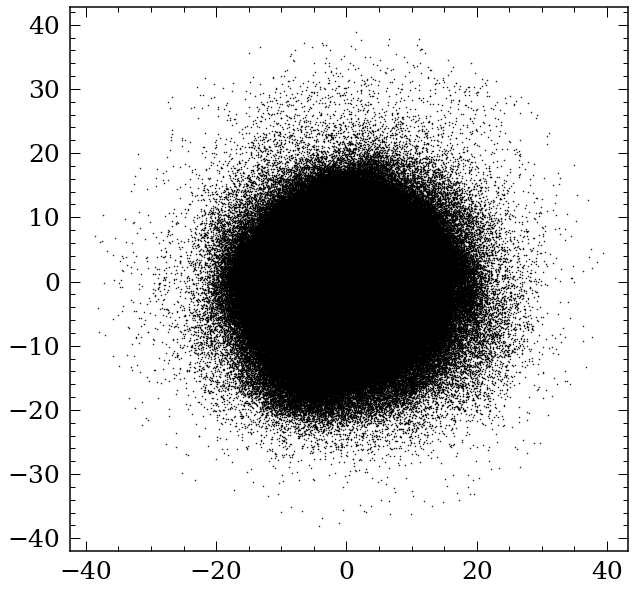

In [5]:
plt.plot(data['x'], data['y'], 'k.', markersize=1)

Text(0, 0.5, '[α/Fe]')

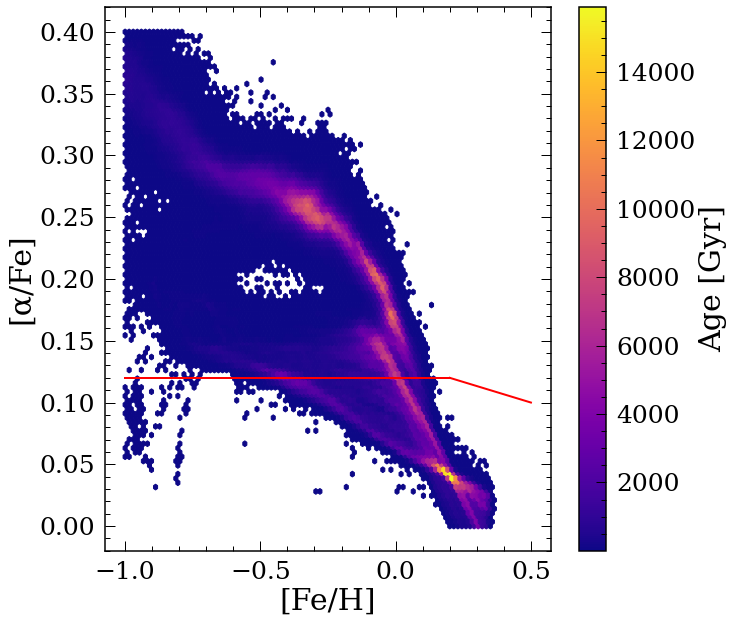

In [6]:
plt.hexbin(data['feh'], data['ofe'], extent=(-1,0.5,0,0.4), cmap='plasma',
          mincnt=1)

plt.plot([-1,0.2], [0.12,0.12], 'r-')
plt.plot([0.2,0.5], [0.12,0.1], 'r-')

def hilow_disk(feh, alpha):
    hi_low = np.zeros(len(feh))
    
    m = feh<0.2
    hi_low[m] = alpha[m]>0.12
    
    p = fitpoints([0.2,0.5], [0.12,0.1])
    hi_low[~m] = alpha[~m]>p(feh[~m])
    
    return hi_low

data['hi_low'] = hilow_disk(data['feh'].values, data['ofe'].values)
#sub_low = data.loc[data['hi_low']==1]
#plt.plot(sub_low['feh'], sub_low['ofe'], 'r.')

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')



100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


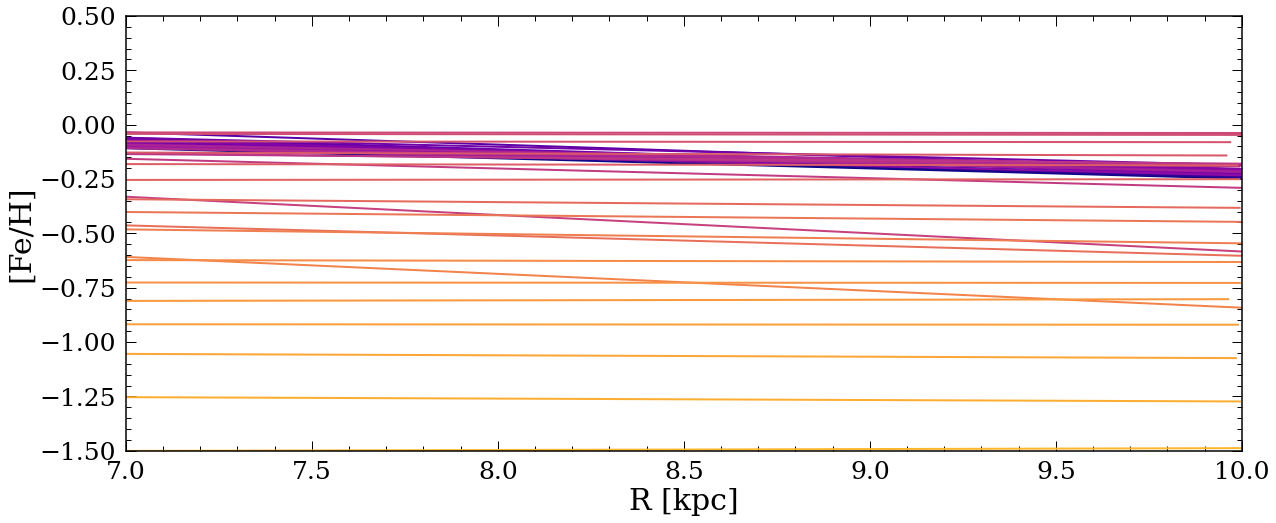

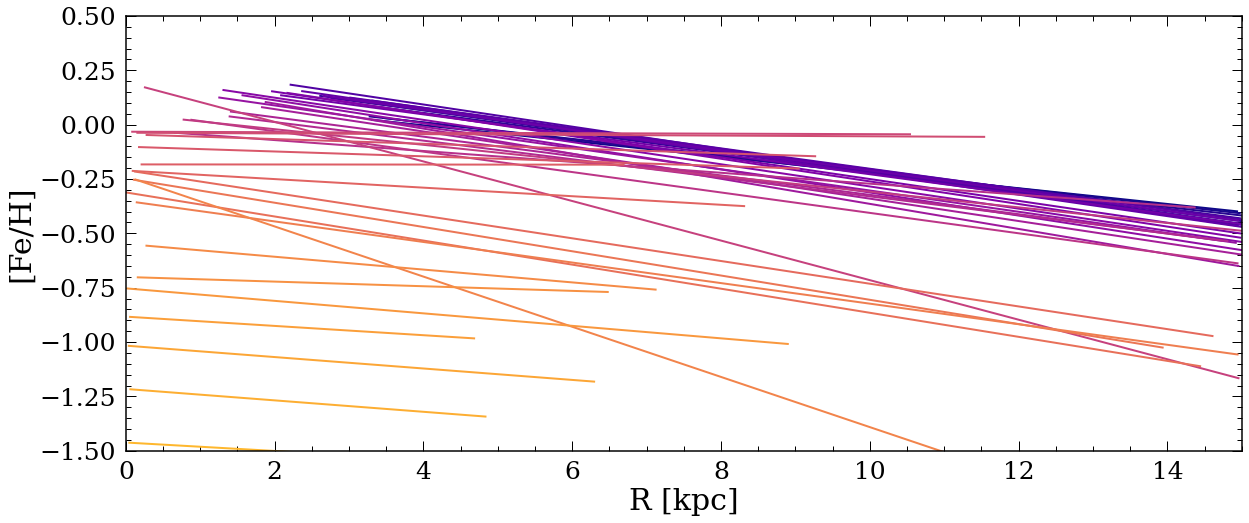

In [141]:
import warnings
warnings.filterwarnings('ignore')

"""monoage(data['feh'].values, data['R'].values, data['age'].values,
        xlims=[0,15])


monoage(data['feh'].values, data['R'].values, data['age'].values,
        xlims=[7,10])
"""
m = (data['R']>7)&(data['R']<10)

ages, slopes, fehscatter = monoage_line(data['feh'].values[m], 
                                        data['R'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[0,15],plotlegend=False)

In [142]:
df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])
pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('g7.55e11_fehscatter.csv', 
                                                index=False)


In [143]:
m2pattern = pd.read_pickle('ISM_slope_g755e11.pkl')
merger = pd.read_pickle('./g7.55e11_merger_Lucy.dat')

In [144]:
mergertimes = np.array(13.8-merger['time'])
mergervir = np.array(merger['vir_ratio'])

disktime = np.array(13.8-m2pattern['time'])
disksize = np.array(m2pattern['half_mass_l2'])

agebin=np.linspace(0,14,50)
mass_ave = np.zeros(len(agebin)-1)
disksize_ave = np.zeros(len(agebin)-1)

agebin=np.linspace(0,14,50)
for i in range(len(agebin)-1):
    m = (mergertimes>agebin[i])&(mergertimes<agebin[i+1])
    m2 = (disktime>agebin[i])&(disktime<agebin[i+1])
    #mass_ave[i] = sum(mergervir[m])
    if sum(m) == 0:
        mass_ave[i] = 0
    else:
        mass_ave[i] = sum(mergervir[m])/sum(m)
        
        
    if sum(m2) == 0:
        disksize_ave[i] = np.nan
    else:
        disksize_ave[i] = np.mean(disksize[m2])
        
diskprop = pd.DataFrame(np.array(((agebin[1:]+agebin[:-1])/2, disksize_ave)).T,
                       columns=['age', 'disksize'])

44


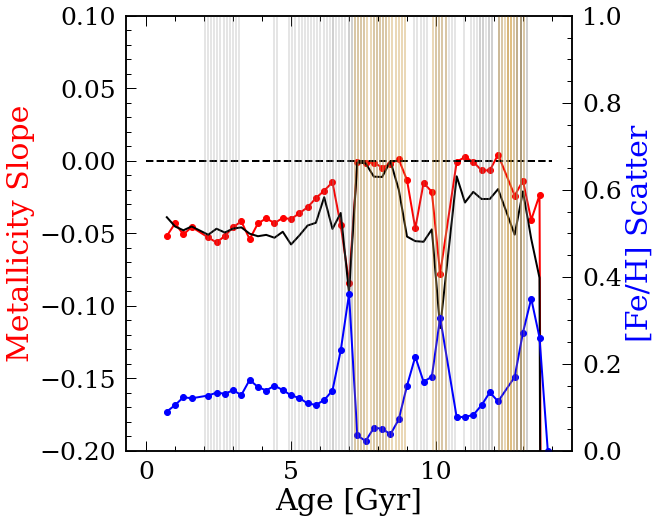

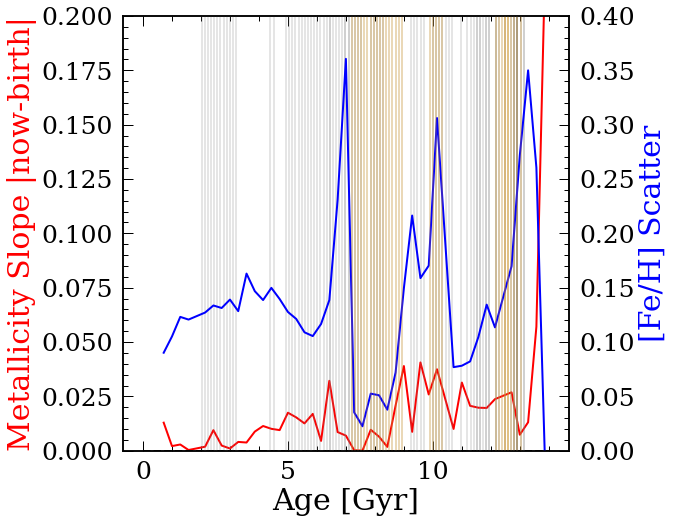

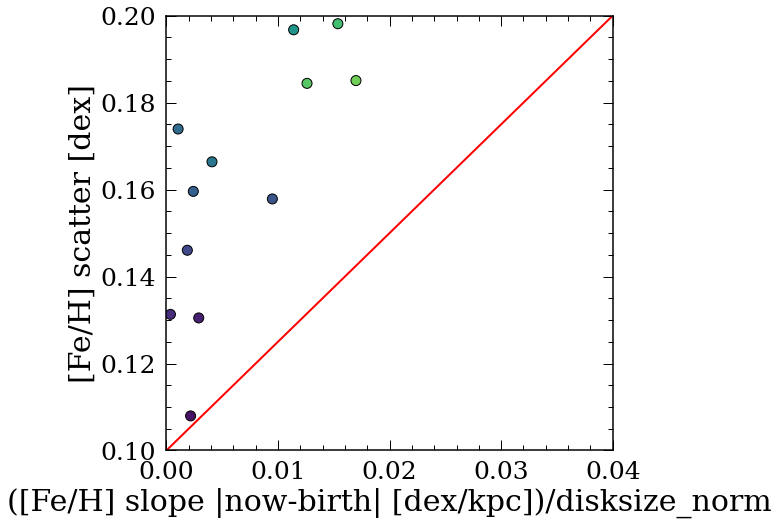

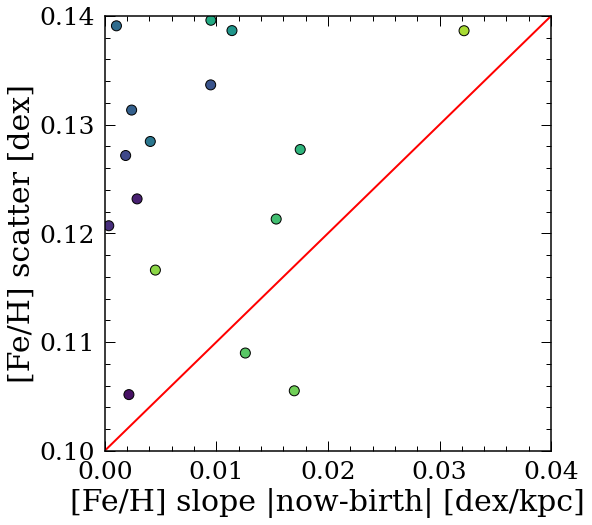

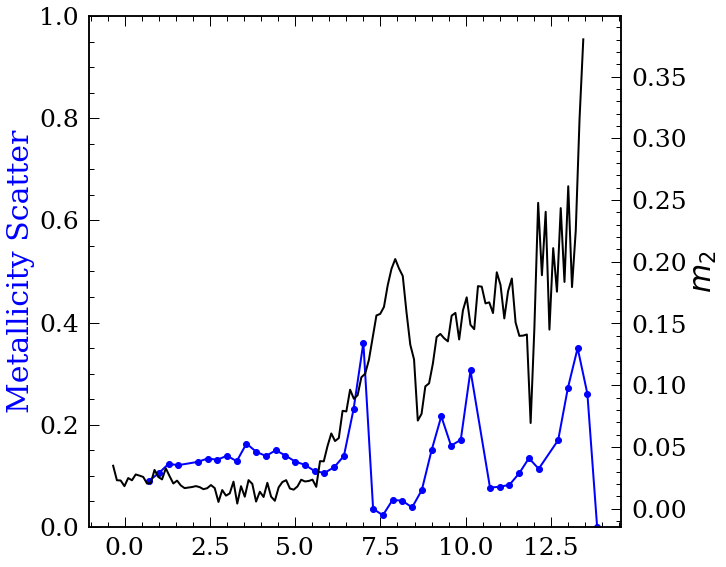

In [150]:

df = pd.read_csv('g7.55e11_fehscatter.csv')
df = pd.merge(df, diskprop, left_on='age', right_on='age', how='inner')
df['disksize_norm'] = df['disksize']/max(df['disksize'])
print(len(df))

plt.figure(figsize=(8,8))
plt.plot(df['age'], df['slopes'], 'r-o')
plt.plot(df['age'], df['slopes_rbir'], 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.2, 0.1])

plt.twinx()
plt.plot(df['age'], df['fehscatter'], 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,1])
#plt.yscale('log')
plt.ylabel('[Fe/H] Scatter', color='b',zorder=5)



plt.figure(figsize=(8,8))
plt.plot(df['age'], abs(df['slopes_rbir']-df['slopes']), 'r-')
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope |now-birth|', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([0, 0.2])

plt.twinx()
plt.plot(df['age'], df['fehscatter'], 'b-')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.4])
#plt.yscale('log')
plt.ylabel('[Fe/H] Scatter', color='b',zorder=5)


plt.figure(figsize=(8,8))
m = df['age']<7.5
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m]/(df['disksize_norm'][m]), 
           c=df['age'][m], s=100, edgecolor='k')
plt.xlabel('([Fe/H] slope |now-birth| [dex/kpc])/disksize_norm')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.04], [0.1,0.2], 'r-')
plt.xlim([0,0.04])
plt.ylim([0.1,0.2])


plt.figure(figsize=(8,8))
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m], 
           c=df['age'][m], s=100, edgecolor='k')
plt.xlabel('[Fe/H] slope |now-birth| [dex/kpc]')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.05], [0.1,0.15], 'r-')
plt.xlim([0,0.04])
plt.ylim([0.1,0.14])



plt.figure(figsize=(10,8))
p = fitpoints(df['age'], df['fehscatter'])
plt.plot(df['age'], df['fehscatter'], 'b-o')
plt.ylabel('Metallicity Scatter', color='b',zorder=10)
plt.ylim([0,1])
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')

100%|██████████| 49/49 [00:19<00:00,  2.51it/s]


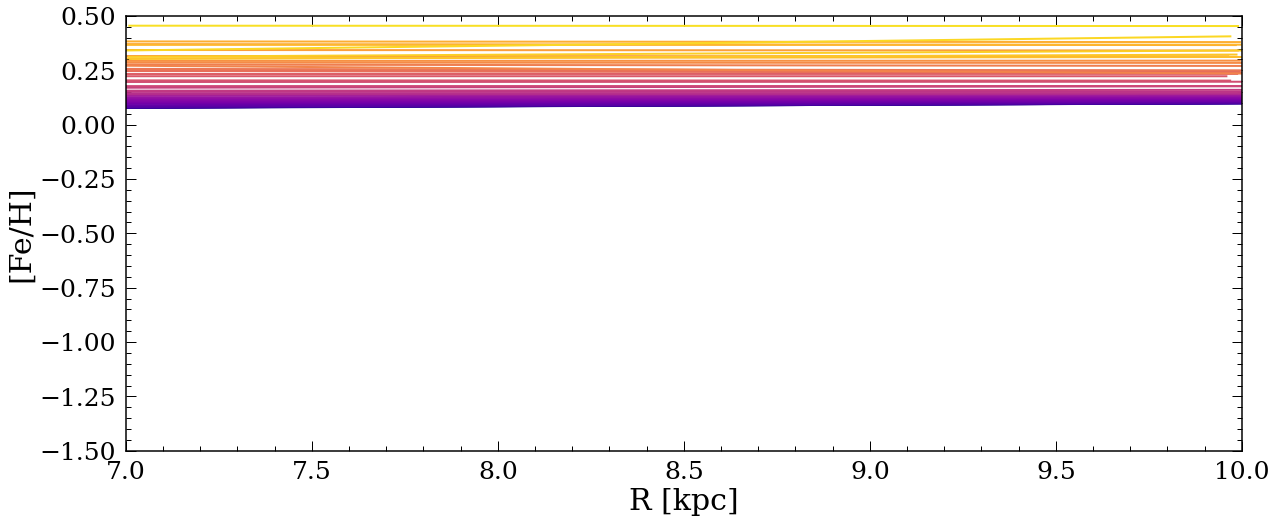

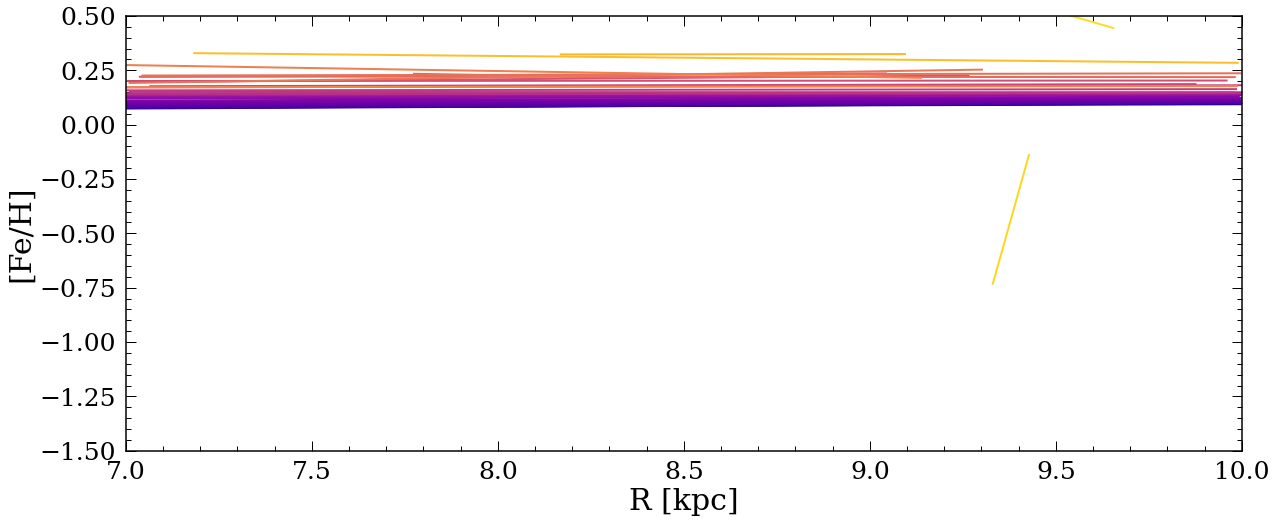

In [151]:
m = (data['R']>7)&(data['R']<10)

ages, slopes, fehscatter = monoage_line(data['ofe'].values[m], 
                                        data['R'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['ofe'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[7,10],plotlegend=False)

In [152]:
df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])
pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('g7.55e11_ofescatter.csv', 
                                                index=False)


Text(0, 0.5, '[α/Fe] Scatter')

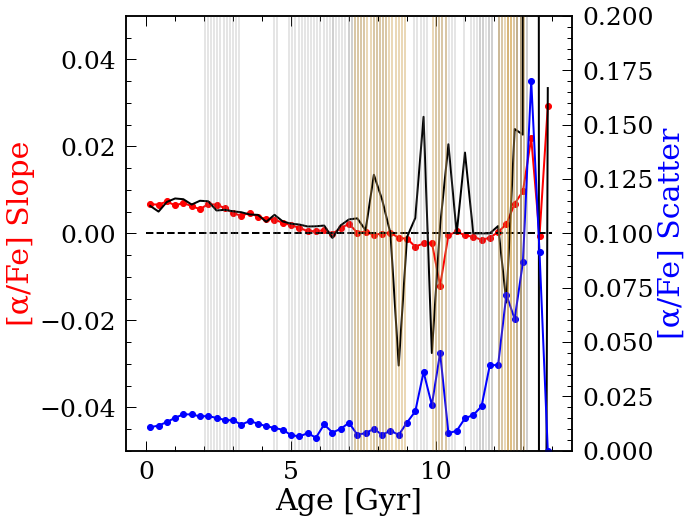

In [153]:
plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.05, 0.05])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.2])
#plt.yscale('log')
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)




## + err

In [7]:
import warnings
warnings.filterwarnings('ignore')

data['age_new'] = [np.random.normal(i, 0.5) for i in data['age']]
data['rbir_new'] = [np.random.normal(i, 1.12+1) for i in data['R_bir']]
data['R_new'] = [np.random.normal(i, 0.31) for i in data['R']]


100%|██████████| 14/14 [00:01<00:00,  8.12it/s]


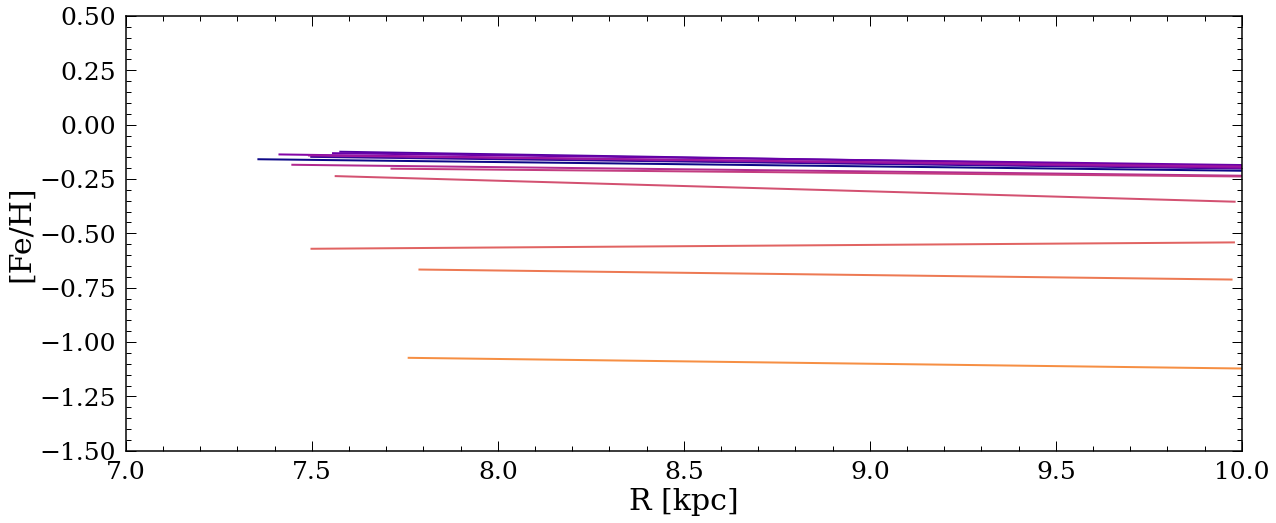

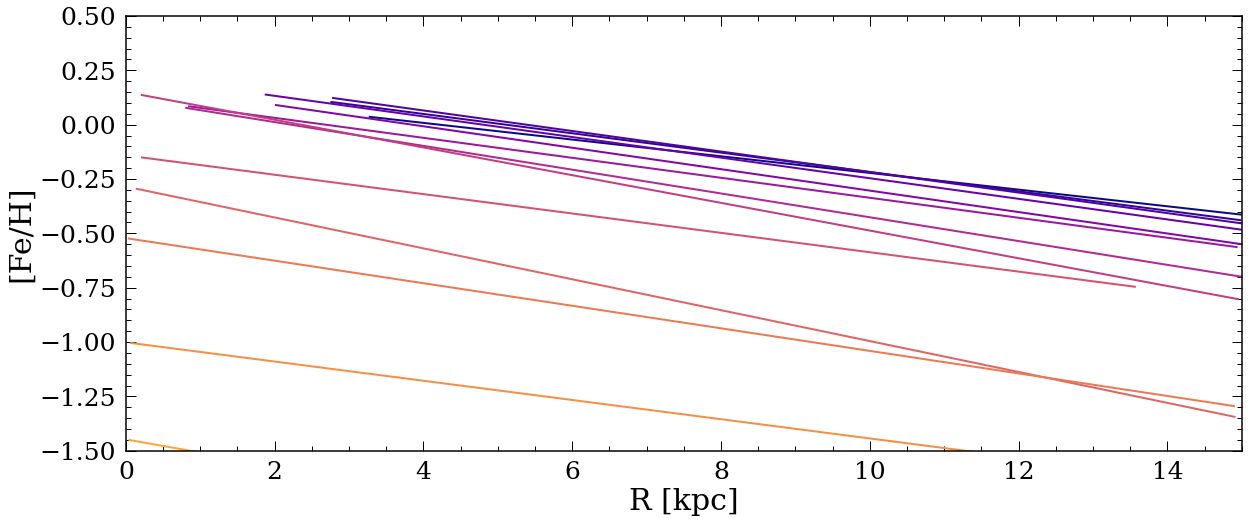

In [8]:
def monoage_line_range(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if plotlegend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter


m = (data['R']>8.5)&(data['R']<9.5)
#m = m&(abs(data['z'])<0.5)
#m = m&(data['Jr'])
#m = m&(data['feh']>-1)
ages, slopes, fehscatter = monoage_line_range(data['feh'].values[m], 
                                        data['R_new'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,15),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,15),
                                        xlims=[0,15],plotlegend=False)




In [9]:
pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('g7.55e11_fehscatter_simdata.csv', 
                                                index=False)



In [125]:
"""ismslope = pd.read_pickle('../NIHAORbirth/ISM_slope_g279e12.pkl')
m2pattern = pd.read_pickle('ISM_slope_g279e12.pkl')
merger = pd.read_pickle('./g2.79e12_merger_Lucy.dat')

mergertimes = 13.8-merger['time']
mergervir = merger['vir_ratio']

agebin=np.linspace(0,14,50)
mass_ave = np.zeros(len(agebin)-1)

agebin=np.linspace(0,14,50)
for i in range(len(agebin)-1):
    m = (mergertimes>agebin[i])&(mergertimes<agebin[i+1])
    #mass_ave[i] = sum(mergervir[m])
    if sum(m) == 0:
        mass_ave[i] = 0
    else:
        mass_ave[i] = sum(mergervir[m])/sum(m)"""

"ismslope = pd.read_pickle('../NIHAORbirth/ISM_slope_g279e12.pkl')\nm2pattern = pd.read_pickle('ISM_slope_g279e12.pkl')\nmerger = pd.read_pickle('./g2.79e12_merger_Lucy.dat')\n\nmergertimes = 13.8-merger['time']\nmergervir = merger['vir_ratio']\n\nagebin=np.linspace(0,14,50)\nmass_ave = np.zeros(len(agebin)-1)\n\nagebin=np.linspace(0,14,50)\nfor i in range(len(agebin)-1):\n    m = (mergertimes>agebin[i])&(mergertimes<agebin[i+1])\n    #mass_ave[i] = sum(mergervir[m])\n    if sum(m) == 0:\n        mass_ave[i] = 0\n    else:\n        mass_ave[i] = sum(mergervir[m])/sum(m)"

7


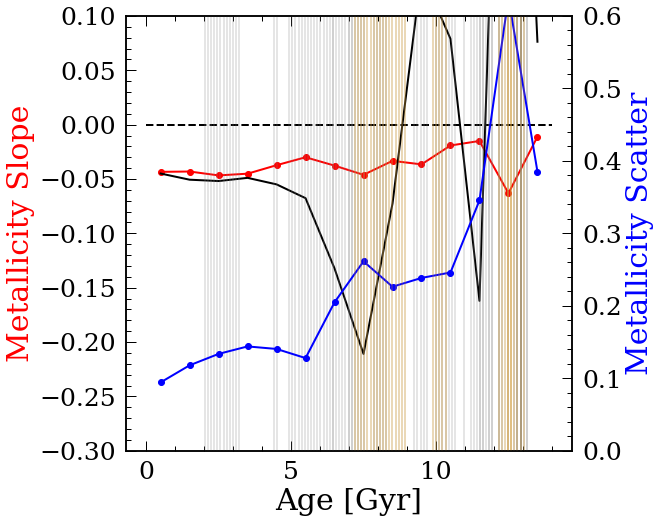

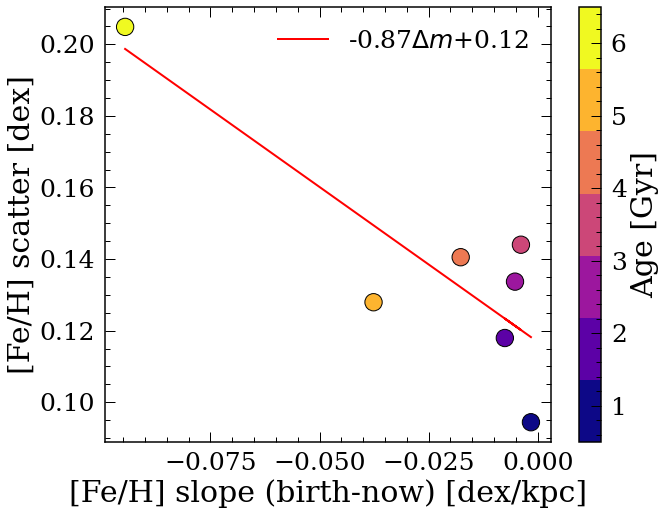

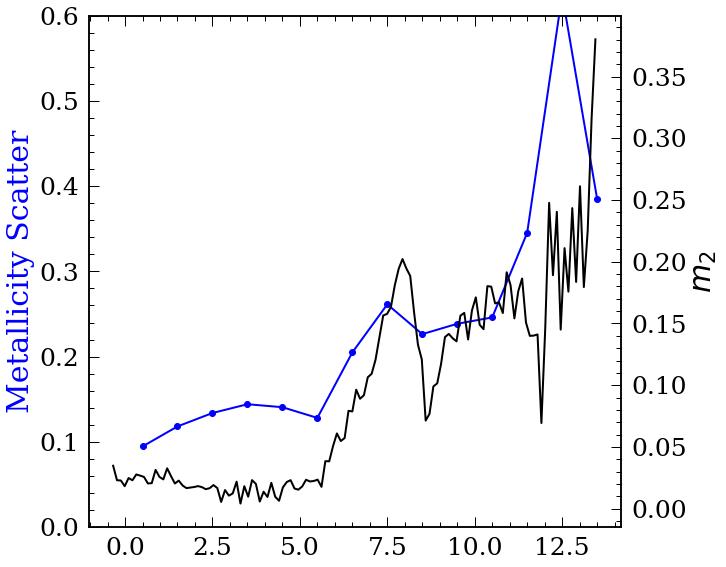

In [156]:
plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.3, 0.1])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.6])
plt.ylabel('Metallicity Scatter', color='b',zorder=5)

"""plt.figure(figsize=(10,8))

plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m]/(df['disksize_norm'][m]), 
           c=df['age'][m], s=100, edgecolor='k', cmap=plt.get_cmap('plasma', sum(m)))
plt.xlabel('([Fe/H] slope |now-birth| [dex/kpc])/disksize_norm')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.15], [0.1,0.35], 'r-')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')"""

df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])


plt.figure(figsize=(10,8))
m = df['age']<7
print(sum(m))
plt.scatter((df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m], 
           c=df['age'][m], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', sum(m)))
p = fitpoints((df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m])
plt.xlabel('[Fe/H] slope (birth-now) [dex/kpc]')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot((df['slopes_rbir']-df['slopes'])[m], 
         p((df['slopes_rbir']-df['slopes'])[m]), 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()

plt.figure(figsize=(10,8))
p = fitpoints(ages, fehscatter)
plt.plot(ages, fehscatter, 'b-o')
plt.ylabel('Metallicity Scatter', color='b',zorder=10)
plt.ylim([0,0.6])
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')

100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


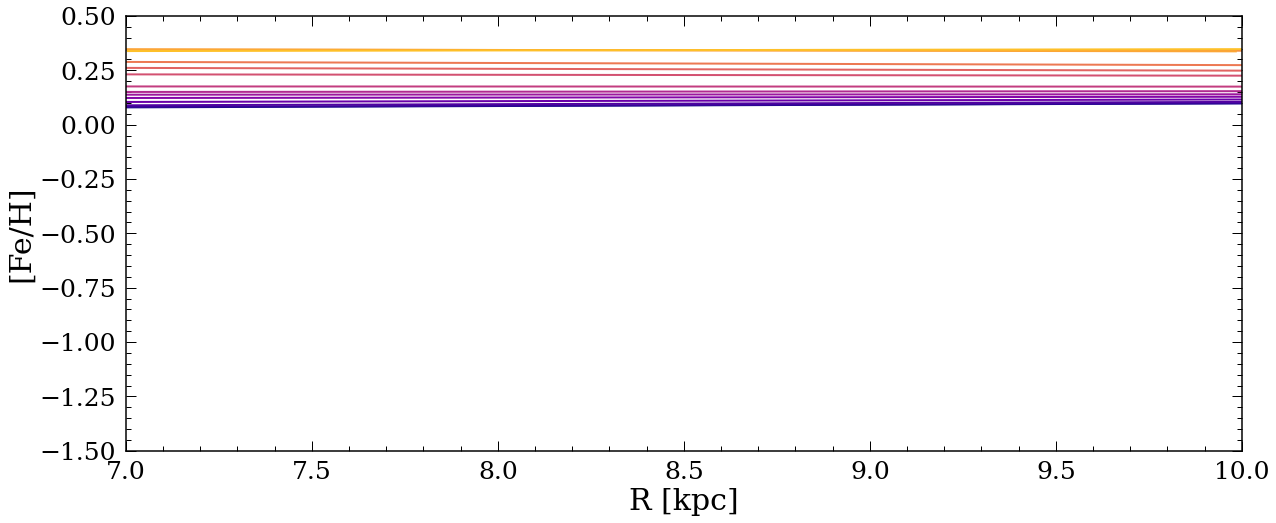

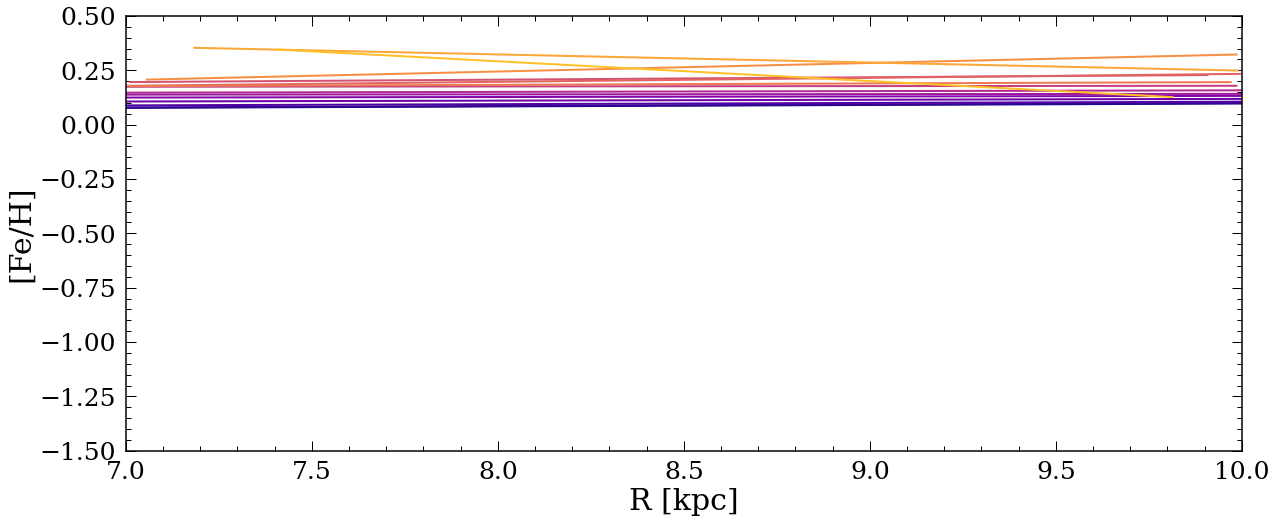

In [157]:
m = (data['R']>7)&(data['R']<10)
ages, slopes, fehscatter = monoage_line(data['ofe'].values[m], 
                                        data['R_new'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,15),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['ofe'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,15),
                                        xlims=[7,10],plotlegend=False)

7


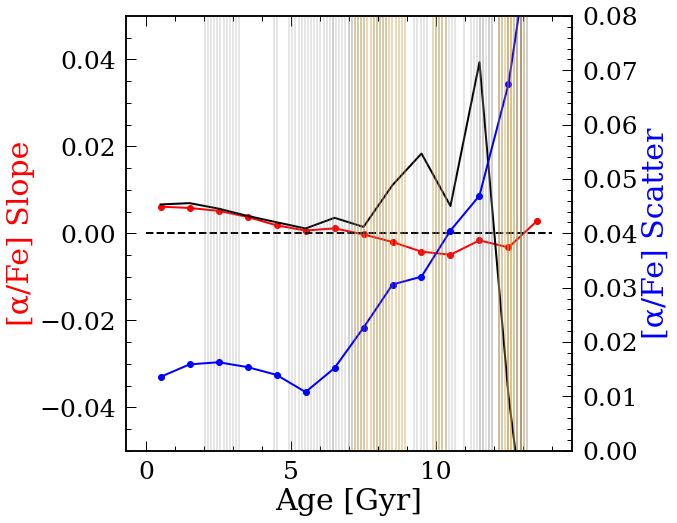

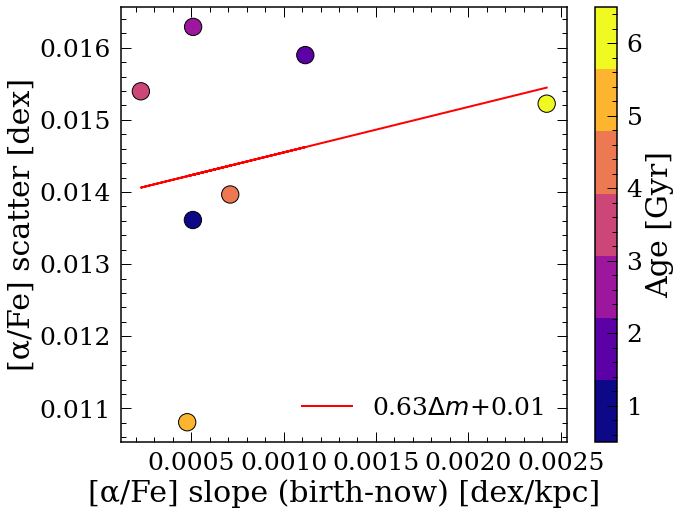

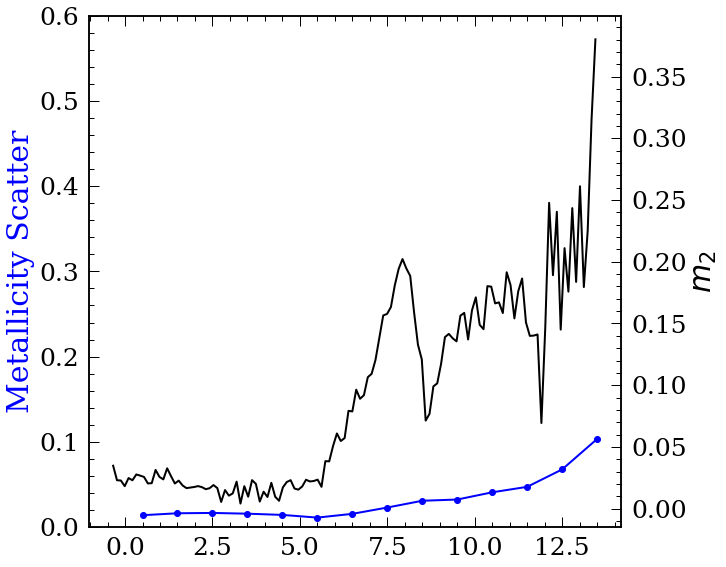

In [165]:
plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.05, 0.05])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.08])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)

"""plt.figure(figsize=(10,8))
m = df['age']<10
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m]/(df['disksize_norm'][m]), 
           c=df['age'][m], s=100, edgecolor='k', cmap=plt.get_cmap('plasma', sum(m)))
plt.xlabel('([Fe/H] slope |now-birth| [dex/kpc])/disksize_norm')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.15], [0,1.5], 'r-')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')"""
df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])

plt.figure(figsize=(10,8))
m = df['age']<7

print(sum(m))
plt.scatter((df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m], 
           c=df['age'][m], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', sum(m)))

#m = m&((df['slopes_rbir']-df['slopes'])<-0.0001)
#m = m&(df['fehscatter']<0.04)

p = fitpoints((df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m])

plt.xlabel('[α/Fe] slope (birth-now) [dex/kpc]')
plt.ylabel('[α/Fe] scatter [dex]')
plt.plot((df['slopes_rbir']-df['slopes'])[m], 
         p((df['slopes_rbir']-df['slopes'])[m]), 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()


plt.figure(figsize=(10,8))
p = fitpoints(ages, fehscatter)
plt.plot(ages, fehscatter, 'b-o')
plt.ylabel('Metallicity Scatter', color='b',zorder=10)
plt.ylim([0,0.6])
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')

In [166]:
df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])
pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('g7.55e11_ofescatter_simdata.csv', 
                                                index=False)



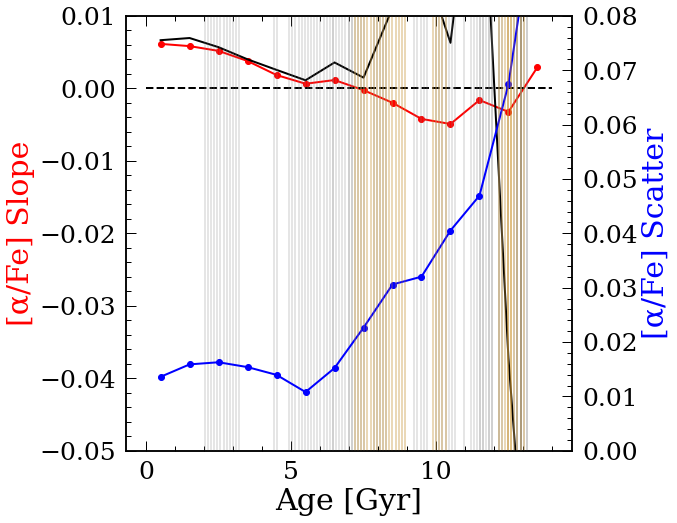

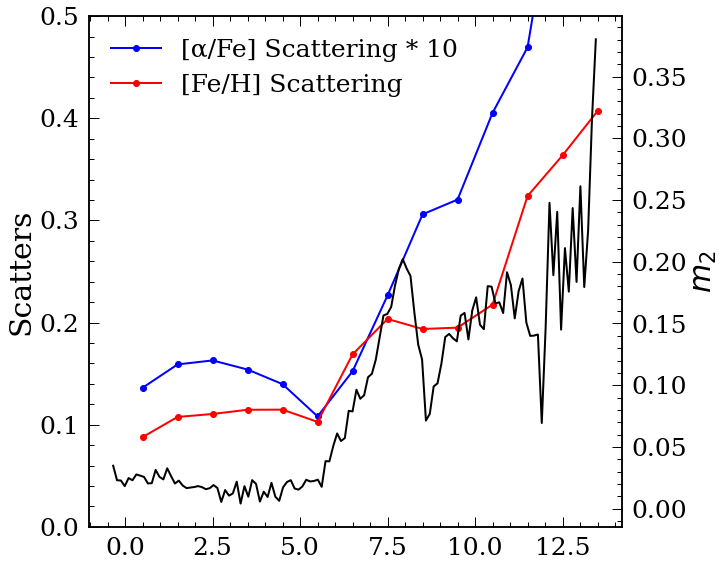

In [167]:
plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.05, 0.01])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.08])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)


df = pd.read_csv('g7.55e11_fehscatter_simdata.csv')
plt.figure(figsize=(10,8))
p = fitpoints(ages, fehscatter)
plt.plot(ages, fehscatter*10, 'b-o', label='[α/Fe] Scattering * 10')
plt.plot(df['age'], df['fehscatter'], 'r-o', label='[Fe/H] Scattering')
plt.ylabel('Scatters',zorder=10)
plt.ylim([0,0.5])
plt.legend(loc=2)
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')